In [6]:
import numpy as np
import pandas as pd
import time
import pickle as pkl

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics

import tensorflow as tf
import keras
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Flatten
import keras.backend as K
import keras.applications as KA
import keras.preprocessing as KP
from keras.utils import to_categorical
from keras.metrics import categorical_accuracy, mean_squared_error

Load data

In [2]:
with open("../assets/datasets/X_train.pkl", 'rb') as X_tr_file:
    X_train = pkl.load(X_tr_file)
with open("../assets/datasets/y_train.pkl", 'rb') as y_tr_file:
    y_train = pkl.load(y_tr_file)
with open("../assets/datasets/X_test.pkl", 'rb') as X_te_file:
    X_test = pkl.load(X_te_file)
with open("../assets/datasets/y_test.pkl", 'rb') as y_te_file:
    y_test = pkl.load(y_te_file)

labels = ["Agaricus_arvensis", "Agaricus_xanthodermus", "Amanita_muscaria", 
          "Amanita_phalloides", "Boletus_edulis", "Calocybe_gambosa",
         "Marasmius_oreades"]

In [3]:
X_train = X_train.reshape(-1,224,224,3)
X_test = X_test.reshape(-1,224,224,3)

labelencoder = LabelEncoder()
y_train_encoded = labelencoder.fit_transform(y_train)
y_test_encoded = labelencoder.transform(y_test)

y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (2958, 224, 224, 3)
y_train (2958, 7)
X_test (162, 224, 224, 3)
y_test (162, 7)


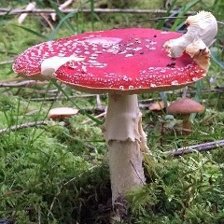

In [4]:
img0 = X_train[0]
x_4d = np.expand_dims(img0, axis=0).astype('float32')
Image.fromarray(img0)

Load model

In [ ]:
####################################
# Load the model
####################################

# ResNet
resnet_model = KA.resnet50.ResNet50()
preprocess = KA.resnet50.preprocess_input
decoder = KA.resnet50.decode_predictions

In [8]:
resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Train a classifier with the features extracted with the network

In [9]:
extract_features_model = Model(inputs=resnet_model.input,
                                 outputs=resnet_model.get_layer("activation_49").output)
features = extract_features_model.predict(preprocess(x_4d.copy()))
features.shape

(1, 7, 7, 2048)

In [13]:
%%time
features_train = []
train_preprocessed = []

for X in X_train:
    x_4d = np.expand_dims(X, axis=0).astype('float32')
    processed = preprocess(x_4d.copy())
    features_train.append(extract_features_model.predict(processed))
    train_preprocessed.append(processed)

with open("../assets/datasets/features_resnet_train.pkl", 'wb') as f:
    pkl.dump(features_train, f)
with open("../assets/datasets/train_resnet_processed.pkl", 'wb') as f:
    pkl.dump(train_preprocessed, f)

In [14]:
%%time
features_test = []
test_preprocessed = []
for X in X_test:
    x_4d = np.expand_dims(X, axis=0).astype('float32')
    processed = preprocess(x_4d.copy())
    features_test.append(extract_features_model.predict(processed))
    test_preprocessed.append(processed)

with open("../assets/datasets/features_resnet_test.pkl", 'wb') as f:
    pkl.dump(features_test, f)
with open("../assets/datasets/test_resnet_processed.pkl", 'wb') as f:
    pkl.dump(test_preprocessed, f)

In [17]:
with open("../assets/datasets/features_resnet_train.pkl", 'rb') as f:
    ft_train = pkl.load(f)
    features_train = np.array(ft_train)
with open("../assets/datasets/features_resnet_test.pkl", 'rb') as f:
    ft_test = pkl.load(f)
    features_test = np.array(ft_test)
with open("../assets/datasets/train_resnet_processed.pkl", 'rb') as f:
    train_preprocessed = pkl.load(f)
    X_train_preprocessed = np.array(train_preprocessed)
with open("../assets/datasets/test_resnet_processed.pkl", 'rb') as f:
    test_preprocessed = pkl.load(f)
    X_test_preprocessed = np.array(test_preprocessed)

In [18]:
model = Sequential()

model.add(Dense(256, activation = "tanh", input_shape = (1, 7, 7, 2048)))
model.add(Flatten())
model.add(Dense(7, activation = "softmax"))

model.compile(optimizer = "rmsprop" , loss = "mean_squared_error", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1, 7, 7, 256)      524544    
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 87815     
Total params: 612,359
Trainable params: 612,359
Non-trainable params: 0
_________________________________________________________________


In [19]:
%%time
model.fit(features_train, y_train, epochs=10)

Epoch 1/10
2958/2958 [==============================] - 7s 2ms/step - loss: 0.1266 - acc: 0.5132
Epoch 2/10
2958/2958 [==============================] - 5s 2ms/step - loss: 0.0718 - acc: 0.7231
Epoch 3/10
2958/2958 [==============================] - 5s 2ms/step - loss: 0.0630 - acc: 0.7634
Epoch 4/10
2958/2958 [==============================] - 5s 2ms/step - loss: 0.0584 - acc: 0.7833
Epoch 5/10
2958/2958 [==============================] - 5s 2ms/step - loss: 0.0514 - acc: 0.8117
Epoch 6/10
2958/2958 [==============================] - 5s 2ms/step - loss: 0.0436 - acc: 0.8377
Epoch 7/10
2958/2958 [==============================] - 5s 2ms/step - loss: 0.0374 - acc: 0.8611
Epoch 8/10
2958/2958 [==============================] - 5s 2ms/step - loss: 0.0318 - acc: 0.8786
Epoch 9/10
2958/2958 [==============================] - 5s 2ms/step - loss: 0.0263 - acc: 0.9013
Epoch 10/10
2958/2958 [==============================] - 5s 2ms/step - loss: 0.0246 - acc: 0.9077
CPU times: user 2min 47s, sys

In [20]:
model.evaluate(features_test, y_test)

162/162 [==============================] - 0s 2ms/step


[0.034202303599428246, 0.8765432098765432]

In [21]:
x = extract_features_model.output
x = model(x)

transfer_resnet_model = Model(inputs=extract_features_model.input, outputs=x)

In [22]:
%%time
i = 0
transfer_resnet_model.predict(test_preprocessed[i]), y_test[i]

CPU times: user 2.09 s, sys: 76.8 ms, total: 2.17 s
Wall time: 960 ms


In [23]:
transfer_resnet_model.save("../assets/models/transfer_resnet_model.h5")

In [23]:
a = extract_features_model.output
x = Dense(256, activation="tanh")(a)
x = Flatten()(x)
x = Dense(100, activation="tanh")(x)
x = Dense(100, activation="tanh")(x)
x = Dense(100, activation="tanh")(x)
x = Dense(7, activation="softmax")(x)

classifier = Model(inputs=extract_features_model.input, outputs=x)

for layer in classifier.layers[:-6]:
    layer.trainable=False
for layer in classifier.layers[-6:]:
    layer.trainable=True

classifier.compile(optimizer = "adam" , loss = "categorical_crossentropy", metrics=["accuracy"])

classifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [24]:
%%time
classifier.fit(X_train, y_train, epochs=5)

Epoch 1/5
2958/2958 [==============================] - 981s 332ms/step - loss: 0.8844 - acc: 0.6761
Epoch 2/5
2958/2958 [==============================] - 952s 322ms/step - loss: 0.2234 - acc: 0.9331
Epoch 3/5
2958/2958 [==============================] - 954s 323ms/step - loss: 0.0836 - acc: 0.9757
Epoch 4/5
2958/2958 [==============================] - 954s 322ms/step - loss: 0.0719 - acc: 0.9773
Epoch 5/5
2958/2958 [==============================] - 958s 324ms/step - loss: 0.0406 - acc: 0.9885
CPU times: user 4h 59min 23s, sys: 10min 25s, total: 5h 9min 48s
Wall time: 1h 20min


In [25]:
classifier.save("../assets/models/transfer_resnet_model_tfalse.h5")

In [7]:
classifier = load_model("../assets/models/transfer_resnet_model.h5")

In [ ]:
predicted = classifier.predict(X_test)
df_cm = pd.DataFrame(metrics.confusion_matrix(y_test.argmax(axis=1), predicted.argmax(axis=1)), index=labels,
                  columns=labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [28]:
classifier.evaluate(X_test, y_test)

162/162 [==============================] - 76s 467ms/step


[1.2379746985058357, 0.6481481481481481]

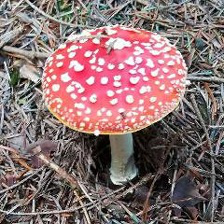

In [29]:
img0 = X_test[0]
x_4d = np.expand_dims(img0, axis=0).astype('float32')
Image.fromarray(img0)

In [32]:
y_test[0], classifier.predict(x_4d)

(array([0., 0., 1., 0., 0., 0., 0.], dtype=float32),
 array([[1.6926790e-02, 2.0225202e-03, 9.2579275e-01, 1.9862952e-04,
         9.7509919e-06, 4.0457021e-03, 5.1003870e-02]], dtype=float32))